In [1]:
# import sys
# !{sys.executable} -m pip install 
# import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import glacierml as gl
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
# raw_dataset = pd.read_csv("~/stuff/coding/glacier/data/T.csv")


#examine data columns
# dataset.head()

2.7.0


In [2]:
#drop everything but lat, long, elevation, thickness
raw_dataset = pd.read_csv("~/data/glac/T_models/T.csv")
dataset = raw_dataset.copy()

dataset = dataset.drop("GLACIER_DB", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("MAXIMUM_THICKNESS", axis=1)
dataset = dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("ELEVATION_DATE", axis=1)
dataset = dataset.drop("SPONSORING_AGENCY", axis=1)
dataset = dataset.drop("REMARKS", axis=1)
dataset = dataset.drop("SURVEY_METHOD_DETAILS", axis=1)
dataset = dataset.drop("SURVEY_METHOD", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_POINTS", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("TOTAL_LENGTH_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("INTERPOLATION_METHOD", axis=1)
dataset = dataset.drop("INVESTIGATOR", axis=1)
dataset = dataset.drop("REFERENCES", axis=1)

dataset_saved_for_later = dataset


dataset = dataset.drop("GLACIER_ID", axis=1)
dataset = dataset.drop("GlaThiDa_ID", axis=1)
#drop the remaining null pieces from elevation
dataset = dataset.dropna()

#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [3]:
# sns.pairplot(train_dataset[["LON","LAT", "AREA", "MEAN_SLOPE", "MEAN_THICKNESS"]], diag_kind='kde')

In [4]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LAT,89.0,47.465341,14.458029,-16.3023,44.584600,45.080000,48.75000,78.87100
LON,89.0,41.704321,55.546192,-134.3600,8.602228,78.176022,79.82588,140.86536
AREA,89.0,4.060882,8.853776,0.0264,1.000000,2.100000,3.22750,71.30000
MEAN_SLOPE,89.0,8.797753,10.230502,0.0000,0.000000,6.000000,16.00000,48.00000
MEAN_THICKNESS,89.0,50.460674,27.011806,4.0000,30.000000,49.000000,65.00000,148.00000


In [5]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MEAN_THICKNESS")
test_labels = test_features.pop("MEAN_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LAT,47.465341,14.458029
LON,41.704321,55.546192
AREA,4.060882,8.853776
MEAN_SLOPE,8.797753,10.230502


# Establish normalization layers

In [6]:
normalizer = {}
variable_list = ('AREA','LAT','LON','MEAN_SLOPE')
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

2022-03-14 21:45:28.675050: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-14 21:45:28.675126: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-14 21:45:28.676328: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Single variable linear regression functions

In [7]:
# glacierml

def build_linear_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss="mean_absolute_error")
    
    return model

def plot_single_model_variable(x, y,feature_name):
    plt.scatter(train_features[feature_name], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature_name)
    plt.ylabel("Avg Thickness (m)")
#     plt.xlim((0,20))
    plt.legend()
      
def plot_loss(history):
#     plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [8]:
test_results = {}
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [9]:
%%time
for variable_name in variable_list:

    linear_model[variable_name] = build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

CPU times: user 2min 11s, sys: 1min 18s, total: 3min 29s
Wall time: 1min 57s


{'AREA': 70.01770782470703,
 'LAT': 27.254735946655273,
 'LON': 29.543182373046875,
 'MEAN_SLOPE': 24.423078536987305}

In [10]:
for variable_name in variable_list:    
    df = pd.DataFrame(linear_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print("")


    Variable       loss   val_loss
999     AREA  16.220636  19.423122

    Variable       loss   val_loss
999      LAT  18.654024  18.652082

    Variable       loss   val_loss
999      LON  19.811071  21.128874

       Variable       loss  val_loss
999  MEAN_SLOPE  17.294561  21.65064



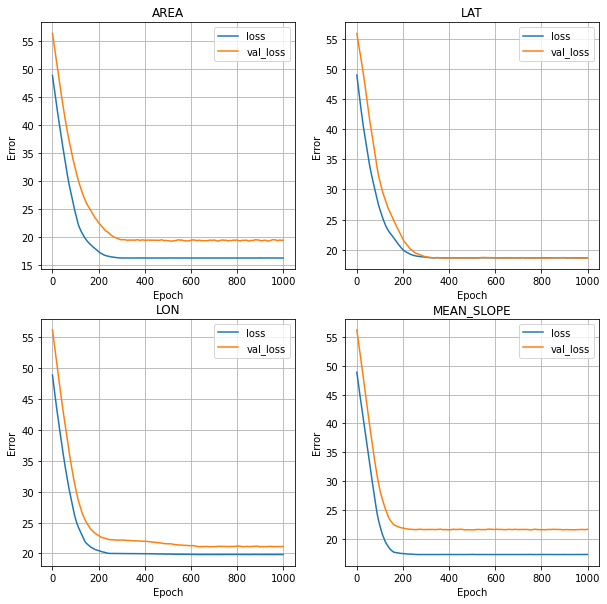

In [11]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(2,2,i+1)
    plt.subplot(2,2,i+1)
    plot_loss(linear_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_loss.eps")

In [12]:
# thiswillcrash()

# Linear regression with multiple inputs

In [13]:
linear_model = build_linear_model(normalizer['ALL'])

history_full = linear_model.fit(
train_features, train_labels,        
   epochs=1000,
   verbose=0,
   validation_split = 0.2)

test_results["MULTI"] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'MULTI': 65.65327453613281}

In [14]:
df = pd.DataFrame(history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)



           Variable       loss   val_loss
999  Multi-Variable  13.855508  19.413677


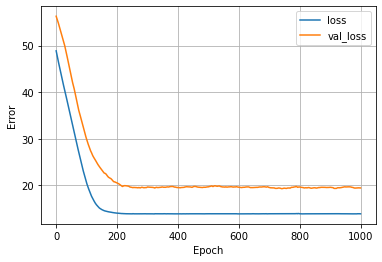

In [15]:
plot_loss(history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

## Define regression functions

In [16]:
def build_dnn_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
    
    return model

def dnn_test_results(feature_name):
    dnn_test_results[feature_name] = dnn_model.evaluate(
        test_features[feature_name],
        test_labels, verbose=0)

In [17]:
test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [18]:
for variable_name in variable_list:

    dnn_model[variable_name] = build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

{'AREA': 63.823890686035156,
 'LAT': 27.258176803588867,
 'LON': 26.980335235595703,
 'MEAN_SLOPE': 21.76813316345215}

In [19]:
for variable_name in variable_list:    
    df = pd.DataFrame(dnn_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print("")


    Variable       loss   val_loss
999     AREA  11.894509  18.470299

    Variable       loss   val_loss
999      LAT  17.903805  17.094669

    Variable       loss   val_loss
999      LON  16.703192  26.916298

       Variable       loss   val_loss
999  MEAN_SLOPE  15.729186  13.382728



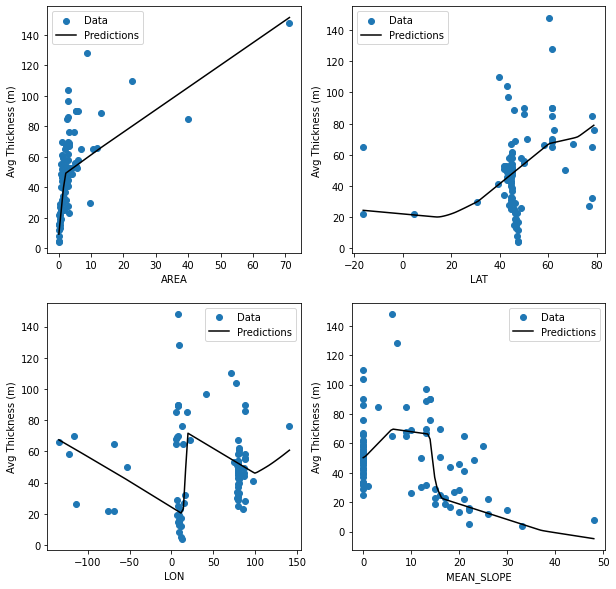

In [20]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = dnn_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

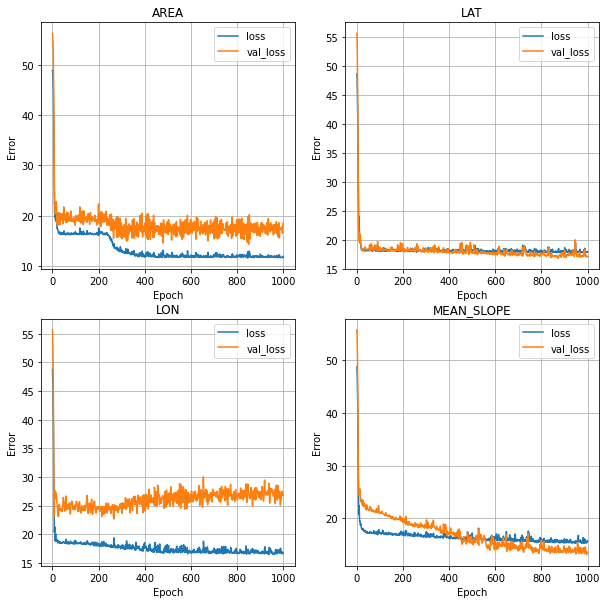

In [21]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(2,2,i+1)
    plot_loss(dnn_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")

# Full model

In [22]:
dnn_full_model = build_dnn_model(normalizer['ALL'])

In [23]:
%%time
dnn_history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: user 49.8 s, sys: 28.3 s, total: 1min 18s
Wall time: 31.8 s


In [24]:
df = pd.DataFrame(dnn_history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)


           Variable      loss   val_loss
999  Multi-Variable  7.693994  12.382131


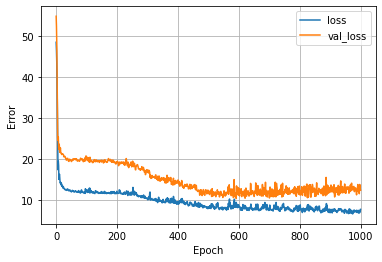

In [25]:
plot_loss(dnn_history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

(0.0, 120.0)

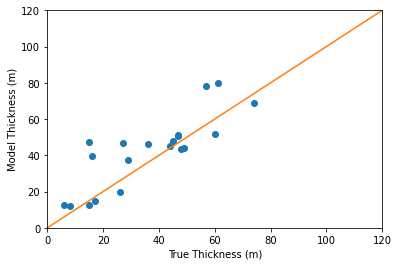

In [26]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,"o")
plt.plot((0,120),(0,120),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,120))
plt.ylim((0,120))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")

In [27]:
#split the dataset and reserve some to test what was trained.
# train_dataset = dataset.sample(frac=0.8, random_state=1)
# test_dataset = dataset.drop(train_dataset.index)


RGI = pd.read_csv("/home/sa42/data/glac/glims/glims_extra/dump2/01_rgi60_Alaska.csv")
RGI = RGI.drop("RGIId", axis=1)
RGI = RGI.drop("GLIMSId", axis=1)
RGI = RGI.drop("BgnDate", axis=1)
RGI = RGI.drop("EndDate", axis=1)
RGI = RGI.drop("O1Region", axis=1)
RGI = RGI.drop("O2Region", axis=1)
RGI = RGI.drop("Zmin", axis=1)
RGI = RGI.drop("Zmed", axis=1)
RGI = RGI.drop("Zmax", axis=1)
RGI = RGI.drop("Aspect", axis=1)
RGI = RGI.drop("Lmax", axis=1)
RGI = RGI.drop("Status", axis=1)
RGI = RGI.drop("Connect", axis=1)
RGI = RGI.drop("Form", axis=1)
RGI = RGI.drop("TermType", axis=1)
RGI = RGI.drop("Surging", axis=1)
RGI = RGI.drop("Linkages", axis=1)
RGI = RGI.drop("Name", axis=1)
RGI.rename(columns = {"CenLon":"LON",
                      "CenLat":"LAT",
                      "Area":"AREA",
                      "Slope":"MEAN_SLOPE"},
           inplace = True)
RGI

,LON,LAT,AREA,MEAN_SLOPE
0,-146.823000,63.689000,0.360,42.0
1,-146.668000,63.404000,0.558,16.0
2,-146.080000,63.376000,1.685,18.0
3,-146.120000,63.381000,3.681,19.0
4,-147.057000,63.551000,2.573,16.0
...,...,...,...,...
27103,-143.726807,60.231728,534.228,10.0
27104,-143.084000,60.532000,0.515,40.0
27105,-129.512000,54.595900,3.564,23.5
27106,-129.548000,54.620600,1.414,27.1


In [28]:
normalizer['ALL'].adapt(np.array(RGI))
y_alaska = dnn_full_model.predict(RGI)
print(y_alaska)

[[13.742]
 [57.964]
 [56.557]
 ...
 [47.834]
 [37.269]
 [66.078]]


In [29]:
RGI["Prethicktion"] = y_alaska

RGI

,LON,LAT,AREA,MEAN_SLOPE,Prethicktion
0,-146.823000,63.689000,0.360,42.0,13.741971
1,-146.668000,63.404000,0.558,16.0,57.963829
2,-146.080000,63.376000,1.685,18.0,56.557056
3,-146.120000,63.381000,3.681,19.0,58.960560
4,-147.057000,63.551000,2.573,16.0,62.266350
...,...,...,...,...,...
27103,-143.726807,60.231728,534.228,10.0,1217.069946
27104,-143.084000,60.532000,0.515,40.0,15.893677
27105,-129.512000,54.595900,3.564,23.5,47.833725
27106,-129.548000,54.620600,1.414,27.1,37.269375


In [30]:
normalizer['ALL'].adapt(np.array(RGI))
y_alaska = dnn_full_model.predict(RGI)
print(y_alaska)

ValueError: in user code:

    File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/engine/base_preprocessing_layer.py", line 118, in adapt_step  *
        self.update_state(data)
    File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/layers/preprocessing/normalization.py", line 222, in update_state  **
        total_mean = self.adapt_mean * existing_weight + batch_mean * batch_weight

    ValueError: Dimensions must be equal, but are 4 and 5 for '{{node add_1}} = AddV2[T=DT_FLOAT](mul, mul_1)' with input shapes: [4], [5].


In [32]:
RGI["thickness_prethicktions"] = y_alaska
RGI.index[RGI["thickness_prethicktions"]<0]

Int64Index([], dtype='int64')

In [33]:
RGI["volume"] = RGI["AREA"] * (RGI["thickness_prethicktions"]/1000)
RGI["volume"].astype(float).sum()

94282.76880240407

In [34]:
#establish normalization layers
alaska_normalizer = {}
variable_list = ("LON",
                 "LAT",
                 "AREA",
                 "MEAN_SLOPE")
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
y_alaska = dnn_full_model.predict(RGI)

print(y_alaska)

InvalidArgumentError:  Incompatible shapes: [32,7] vs. [1,4]
	 [[node sequential_9/normalization_4/sub
 (defined at /home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/layers/preprocessing/normalization.py:257)
]] [Op:__inference_predict_function_246275]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_9/normalization_4/sub:
In[0] sequential_9/Cast (defined at /home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/engine/functional.py:671)	
In[1] sequential_9/normalization_4/sub/y:

Operation defined at: (most recent call last)
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/runpy.py", line 193, in _run_module_as_main
>>>     "__main__", mod_spec)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/runpy.py", line 85, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
>>>     handle._run()
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/asyncio/events.py", line 88, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
>>>     raw_cell, store_history, silent, shell_futures)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3173, in run_cell_async
>>>     interactivity=interactivity, compiler=compiler, result=result)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_2161899/3640397436.py", line 14, in <module>
>>>     y_alaska = dnn_full_model.predict(RGI)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/engine/training.py", line 1789, in predict
>>>     tmp_batch_outputs = self.predict_function(iterator)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/engine/training.py", line 1621, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/engine/training.py", line 1611, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/engine/training.py", line 1604, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/engine/training.py", line 1572, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/engine/functional.py", line 452, in call
>>>     inputs, training=training, mask=mask)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/keras/layers/preprocessing/normalization.py", line 257, in call
>>>     return ((inputs - self.mean) /
>>> 

In [ ]:
# dataset_saved_for_later


# dataset_saved_for_later = dataset_saved_for_later.drop("GLACIER_ID", axis=1)
# dataset_saved_for_later = dataset_saved_for_later.drop("GlaThiDa_ID", axis=1)
# #drop the remaining null pieces from elevation
# dataset_saved_for_later = dataset_saved_for_later.dropna()
# dataset_saved_for_later.isna().sum()
dataset_saved_for_later

In [ ]:
test_features

In [ ]:
y_alaska_test = dnn_full_model.predict(RGI)

In [ ]:
plt.plot(y_alaska_test,".")
# plt.plot((0,1000),(0,1000),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((-10,3000))
plt.ylim((-200,300))

In [ ]:
print(y_alaska_test)